In [1]:
import datetime
import os

import laspy
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import torch
import geopandas as gpd
import py4dgeo

import pipeline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Debuging Parameters

In [2]:
log_dir = f"outputs/{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
nth = 1

os.makedirs(log_dir, exist_ok=True)
print(f"Logging to {log_dir}")
print(f"Plotting every {nth}th point")

Logging to outputs/20250522-0105
Plotting every 1th point


### Parameters

In [3]:
# Cloud No. 1
cloud1_file = "datasets/Tongjiang_Aerial/Cloud1_overlap.las"
las1 = laspy.read(cloud1_file)
x1, y1, z1 = las1.x, las1.y, las1.z
r1, g1, b1 = las1.red, las1.green, las1.blue

colors1 = np.vstack((r1, g1, b1)).T
if colors1.max() > 1:
    colors1 = colors1.astype(np.float32) / 65535.0

# Cloud No. 4
cloud4_file = "datasets/Tongjiang_Aerial/Cloud4_overlap.las"
las4 = laspy.read(cloud4_file)
x4, y4, z4 = las4.x, las4.y, las4.z
r4, g4, b4 = las4.red, las4.green, las4.blue

colors4 = np.vstack((r4, g4, b4)).T
if colors4.max() > 1:
    colors4 = colors4.astype(np.float32) / 65535.0

# Stable area shapefile
shp_file = "datasets/Tongjiang_Aerial/stable_overlap.shp"
stable_shp = gpd.read_file(shp_file)

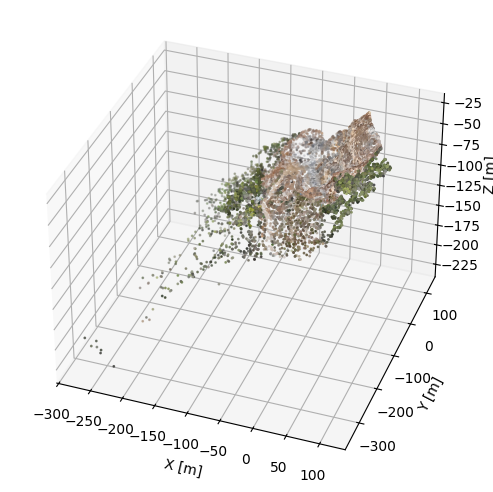

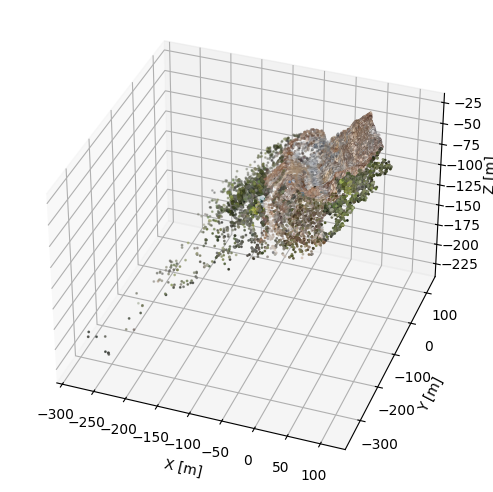

In [4]:
idx = slice(None, None, 100)

# Plotting cloud 1
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))
sc = ax.scatter(
    x1[idx], y1[idx], z1[idx],
    c=colors1[idx],
    s=1,
    marker='o'
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=35.0, azim=290.0)
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_Raw_RGB_1.png", dpi=300, bbox_inches="tight")
plt.show()

# Plotting cloud 4
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))
sc = ax.scatter(
    x4[idx], y4[idx], z4[idx],
    c=colors4[idx],
    s=1,
    marker='o'
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=35.0, azim=290.0)
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_Raw_RGB_4.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
DEVICE = torch.device("cuda:{}".format(0))
PADDING = "same"
VOXEL_SIZE = 2.0
PV = 5
NV = -1
PPV = -1
NUM_WORKERS = 24
ROTATION_CHOICE = "gen"

QUANTILE_THR = 0.2
ICP_VERSION = "generalized"
MAX_ITER = 2048

In [6]:
rot = 45
tas = 10
T = pipeline.get_random_transformation(
    angle_range_z=((-rot - 2.5, -rot + 2.5), (rot - 2.5, rot + 2.5)),
    translation_range=((-tas - 0.5, -tas + 0.5), (tas - 0.5, tas + 0.5)),
)

x4_trans, y4_trans, z4_trans = pipeline.apply_transformation(x4, y4, z4, T)

print("Ground truth transformation matrix (4x4):", "\n", np.linalg.inv(T))

Ground truth transformation matrix (4x4): 
 [[ 6.75921028e-01  7.36652414e-01  2.17711817e-02  1.13474112e-01]
 [-7.36795703e-01  6.76112405e-01 -2.02678124e-03 -1.43376086e+01]
 [-1.62127993e-02 -1.46709690e-02  9.99760925e-01  9.81671239e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Registration wit EGS

In [7]:
source = np.vstack((x4_trans, y4_trans, z4_trans)).T
target = np.vstack((x1, y1, z1)).T

In [8]:
start_timestamp = datetime.datetime.now()

EGS_T = pipeline.EGS(
    source=source,
    target=target,
    voxel_size=VOXEL_SIZE,
    padding=PADDING,
    ppv=PPV,
    pv=PV,
    nv=NV,
    num_workers=NUM_WORKERS,
    rotation_choice=ROTATION_CHOICE,
    rotation_root_path="exhaustive-grid-search/data/rotations",
)

GICP_T = pipeline.auto_GICP(
    source=source, target=target, T_init=EGS_T, thr=QUANTILE_THR, max_iter=MAX_ITER
)

end_timestamp_REG = datetime.datetime.now()
print("EGS time:", end_timestamp_REG - start_timestamp)

FFT Convolution: 100%|██████████| 1656/1656 [04:16<00:00,  6.45it/s]


0.40644605790482147
EGS time: 0:04:22.224213


In [9]:
gt = np.linalg.inv(T)

rre = pipeline.compute_rre(EGS_T, gt)
rte = pipeline.compute_rte(EGS_T, gt)
print("Rotation error (degrees):", rre)
print("Translation error (m):", rte)

rre_refined = pipeline.compute_rre(GICP_T, gt)
rte_refined = pipeline.compute_rte(GICP_T, gt)
print("Refined rotation error (degrees):", rre_refined)
print("Refined translation error (m):", rte_refined)

x4_refined, y4_refined, z4_refined = pipeline.apply_transformation(x4_trans, y4_trans, z4_trans, GICP_T)
cloud4_refined = np.vstack((x4_refined, y4_refined, z4_refined)).T

Rotation error (degrees): 2.476158221017281
Translation error (m): 2.5967355595716892
Refined rotation error (degrees): 0.0
Refined translation error (m): 0.023231982972785212


### Change Detection

```bash
git submodule update --init --recursive
cd py4dgeo
python -m pip install -v --editable .
```

In [10]:
stable_before, mask_before = pipeline.isolate_stable(target, stable_shp)
stable_after,  mask_after  = pipeline.isolate_stable(cloud4_refined, stable_shp)

epoch_stable_before = py4dgeo.Epoch(stable_before)
epoch_stable_after  = py4dgeo.Epoch(stable_after)

# C2C distances computation
epoch_stable_after.build_kdtree()
indices, distances = epoch_stable_after.kdtree.nearest_neighbors(
    epoch_stable_before.cloud, 1
)
distances = np.sqrt(distances)

print(f"C2C Median distances: {np.median(distances):.3f} m")
print(f"C2C Std. dev. of distances: {np.std(distances):.3f} m")
print(f"C2C max of distances: {np.max(distances):.3f} m")

[2025-05-22 01:09:52][INFO] Building KDTree structure with leaf parameter 10
C2C Median distances: 0.112 m
C2C Std. dev. of distances: 0.042 m
C2C max of distances: 0.454 m


In [11]:
avg_spacing = pipeline.estimate_avg_spacing(target)
print("Estimated average spacing:", avg_spacing)

# Define a target downsampling ratio
ref_ratio = 0.01
init_voxel_size = avg_spacing / ref_ratio

# Adaptively determine the voxel size
adapted_voxel_size = pipeline.adaptive_voxel_size(target, ref_ratio, init_voxel_size, 25, 15, 1)
print("Adapted voxel size:", adapted_voxel_size)

# Downsample using the final voxel size
down_source = pipeline.voxel_downsample(target, adapted_voxel_size)
print(f"Original points: {len(target)}, Downsampled points: {len(down_source)}")

Estimated average spacing: 0.1992679629347762
0.0005847051068920766
Voxel size: 49.353551227256034, error: 0.009415294893107924, scale: 0.9069443499564986
0.00011111554614369721
Voxel size: 43.291034543666996, error: 0.009888884453856304, scale: 0.7758801857914975
0.00014240050573755372
Voxel size: 36.720838783710114, error: 0.009857599494262447, scale: 0.6112790348255848
0.00018878854927327198
Voxel size: 30.175063756172143, error: 0.009811211450726729, scale: 0.4149505065025193
0.0002610675938521818
Voxel size: 24.07248638228471, error: 0.009738932406147819, scale: 0.18900417107676604
0.0004045468912998685
Voxel size: 18.692138055950277, error: 0.009595453108700133, scale: -0.06396236271768896
0.0006817963608040451
Voxel size: 14.171942913245664, error: 0.009318203639195955, scale: -0.3408012145011048
0.0011079190863065732
Voxel size: 10.52626110392527, error: 0.008892080913693427, scale: -0.6381921811184428
0.0019493766202102996
Voxel size: 7.697131688744179, error: 0.00805062337978

In [12]:
m3c2 = py4dgeo.M3C2(
    epochs=(epoch_stable_before, epoch_stable_after),
    corepoints=epoch_stable_before.cloud[::],
    normal_radii=(adapted_voxel_size * 2.0,),
    cyl_radius=(adapted_voxel_size),
    max_distance=(15.0),
    registration_error=(0.0),
)
m3c2_distances_stableparts, uncertainties_stableparts = m3c2.run()
reg_target_source = np.nanstd(m3c2_distances_stableparts)

print(f"M3C2 Median distances: {np.nanmedian(m3c2_distances_stableparts):.3f} m")
print(f"M3C2 Std. dev. of distances: {np.nanstd(m3c2_distances_stableparts):.3f} m")
print(f"Registration error {reg_target_source:.3f} m.")

[2025-05-22 01:10:03][INFO] Building KDTree structure with leaf parameter 10
M3C2 Median distances: 0.002 m
M3C2 Std. dev. of distances: 0.024 m
Registration error 0.024 m.


In [13]:
epoch_before = py4dgeo.Epoch(target)
epoch_after = py4dgeo.Epoch(cloud4_refined)

corepoints_pcd        = o3d.geometry.PointCloud()
corepoints_pcd.points = o3d.utility.Vector3dVector(epoch_before.cloud)
corepoints_pcd        = corepoints_pcd.voxel_down_sample(voxel_size=adapted_voxel_size)#0.1)
corepoints            = np.asarray(corepoints_pcd.points)

m3c2 = py4dgeo.M3C2(
    epochs=(epoch_before, epoch_after),
    corepoints=corepoints,
    normal_radii=(adapted_voxel_size * 2.0,),
    cyl_radius=(adapted_voxel_size),
    max_distance=(15.0),
    registration_error=(reg_target_source),
)
m3c2_distances, uncertainties = m3c2.run()
change_sign = np.where(abs(m3c2_distances) > uncertainties["lodetection"], True, False)

[2025-05-22 01:10:05][INFO] Building KDTree structure with leaf parameter 10
[2025-05-22 01:10:05][INFO] Building KDTree structure with leaf parameter 10


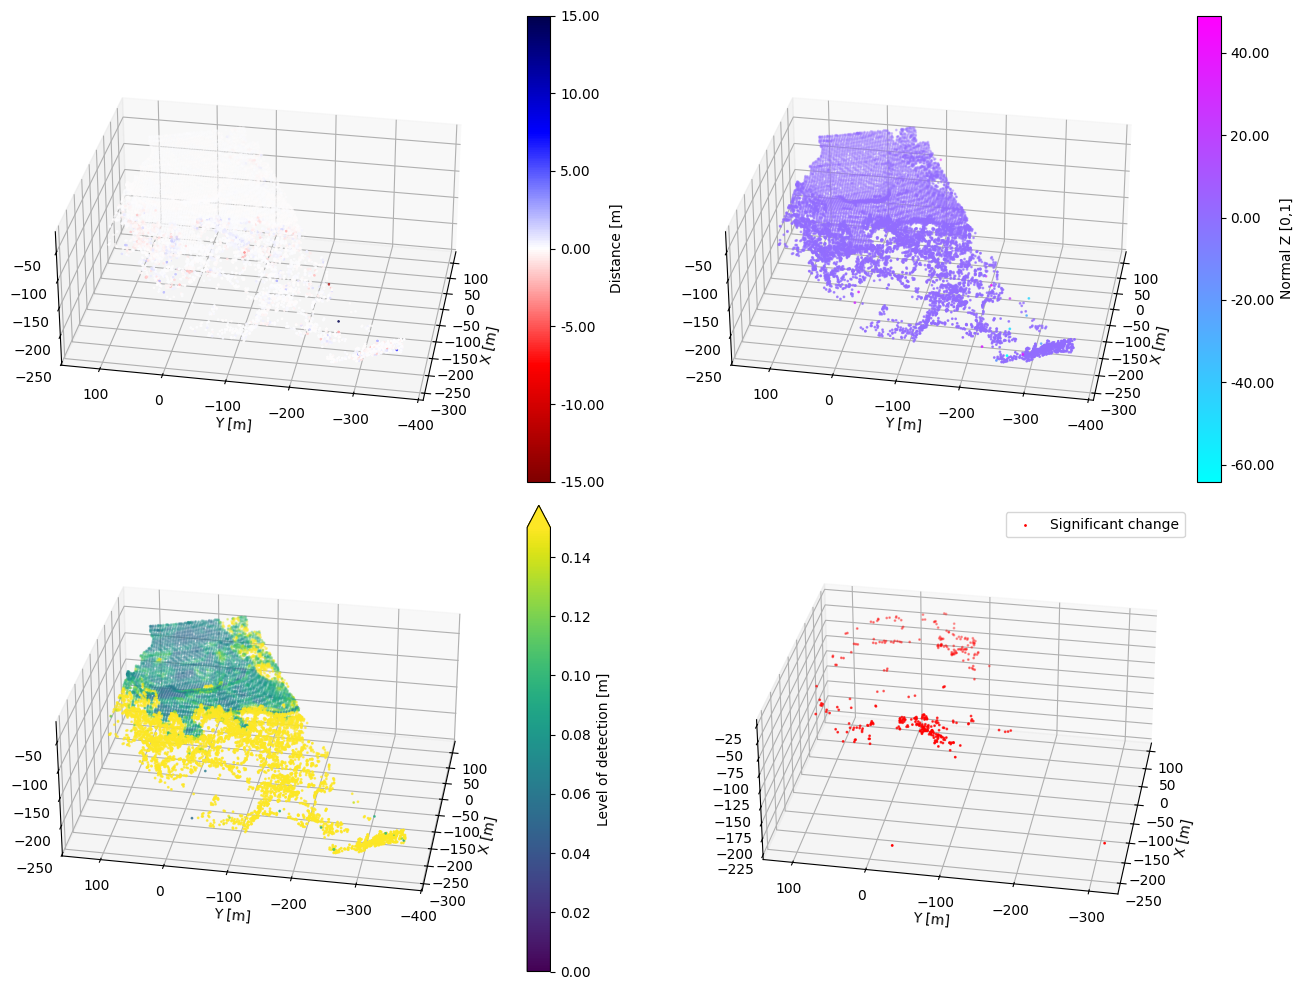

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={"projection": "3d"})
(ax1, ax2), (ax3, ax4) = axs

# Plot the distances
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=m3c2_distances,
    cmap="seismic_r",
    vmin=-15.0,
    vmax=15.0,
    s=1,
    marker='*',
)
plt.colorbar(d, format=("%.2f"), label="Distance [m]", ax=ax1)

# Plot the directions
directions = m3c2.directions()
dz = ax2.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=directions[:, 2],
    cmap="cool",
    s=1,
)
plt.colorbar(dz, format=("%.2f"), label="Normal Z [0,1]", ax=ax2)

# Plot the level of detection values
l = ax3.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=uncertainties["lodetection"],
    cmap="viridis",
    vmin=0.0,
    vmax=0.15,
    s=1,
)
plt.colorbar(
    l,
    format=("%.2f"),
    label="Level of detection [m]",
    ax=ax3,
    extend="max",
)

# Plot the significant change values (boolean)
ax4.scatter(
    corepoints[change_sign][:, 0],
    corepoints[change_sign][:, 1],
    corepoints[change_sign][:, 2],
    label="Significant change",
    c="red",
    s=1,
)
ax4.legend()

# Add plot elements
for ax_set in axs:
    for ax in ax_set:
        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")
        ax.set_aspect("equal")
        ax.view_init(elev=30.0, azim=190.0)

plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet.png", dpi=300, bbox_inches="tight")
plt.show()

### Volume Calculation

In [15]:
hulls = pipeline.segment_changes(corepoints, change_sign)

selected_indices    = [np.argmax([hull.area for hull in hulls])]
selected_hulls      = [hulls[i] for i in selected_indices]
inside_mask_refined = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, cloud4_refined[:, :2])
inside_mask_raw     = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, target[:, :2])

filtered_refined = cloud4_refined[inside_mask_refined]
filtered_raw     = target[inside_mask_raw]

filtered_refined_x, filtered_refined_y, filtered_refined_z = filtered_refined.T
filtered_raw_x, filtered_raw_y, filtered_raw_z = filtered_raw.T

In [16]:
dem_before, dem_after, dem_grid_x, dem_grid_y, grid_res = pipeline.reletive_DEM(
    filtered_raw,
    filtered_refined,
    grid_res=None,
    method="linear",
    mask_hulls=selected_hulls,
)

net_volume, cut_volume, fill_volume, diff_DEMs = pipeline.calculate_volume(
    dem_before, dem_after, grid_res=grid_res, threshold=reg_target_source
)

In [17]:
print("Cut Volume (removed): {} m³".format(cut_volume))
print("Fill Volume (added): {} m³".format(fill_volume))
print("Net Volume Change: {} m³".format(net_volume))
print(grid_res)

Cut Volume (removed): 2.434609742370899 m³
Fill Volume (added): 3.2125861984033994 m³
Net Volume Change: 0.7779764560325004 m³
0.057810910282112854


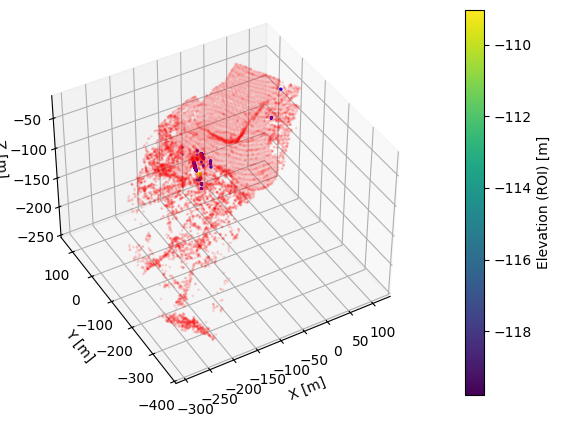

In [18]:
unselected_hulls = [
    hulls[i] for i in range(len(hulls)) if i not in selected_indices
]
inside_nonroi_raw = pipeline.is_inside_selected_hulls_vectorized(
    unselected_hulls, target[:, :2]
)

mask_combined = np.logical_and(~inside_nonroi_raw, ~inside_mask_raw)
unfiltered_raw = target[mask_combined]

filtered_raw_nonroi   = target[inside_nonroi_raw]
filtered_raw_nonroi_x = filtered_raw_nonroi[:, 0]
filtered_raw_nonroi_y = filtered_raw_nonroi[:, 1]
filtered_raw_nonroi_z = filtered_raw_nonroi[:, 2]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

unfiltered_raw_pcd        = o3d.geometry.PointCloud()
unfiltered_raw_pcd.points = o3d.utility.Vector3dVector(unfiltered_raw)
unfiltered_raw_pcd        = unfiltered_raw_pcd.voxel_down_sample(voxel_size=4)
unfiltered_raw_ds         = np.asarray(unfiltered_raw_pcd.points)

unfiltered_raw_x = unfiltered_raw_ds[:, 0]
unfiltered_raw_y = unfiltered_raw_ds[:, 1]
unfiltered_raw_z = unfiltered_raw_ds[:, 2]

scatter_unaffected = ax.scatter(
    filtered_raw_x[::1],
    filtered_raw_y[::1],
    filtered_raw_z[::1],
    c=filtered_raw_z[::1],
    cmap="viridis",
    s=1,
    marker="o",
)
scatter_affected = ax.scatter(
    unfiltered_raw_x[::1],
    unfiltered_raw_y[::1],
    unfiltered_raw_z[::1],
    c="red",
    s=1,
    marker="o",
    alpha=0.1,
)
scatter_unselect = ax.scatter(
    filtered_raw_nonroi_x[::1],
    filtered_raw_nonroi_y[::1],
    filtered_raw_nonroi_z[::1],
    c="blue",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=40.0, azim=240.0)

cbar = plt.colorbar(scatter_unaffected, ax=ax, pad=0.1)
cbar.set_label("Elevation (ROI) [m]")

plt.savefig(f"{log_dir}/ROI.png", dpi=300, bbox_inches="tight")
plt.show()

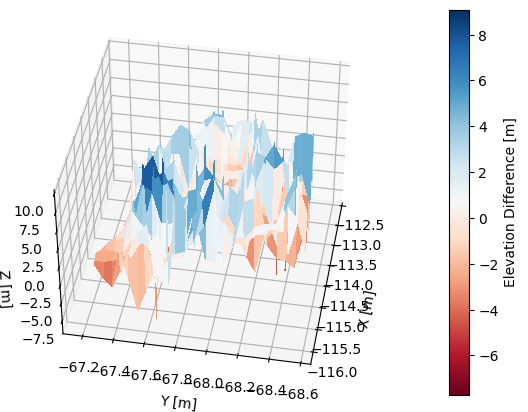

In [19]:
diff_masked = np.ma.masked_invalid(diff_DEMs)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    dem_grid_x, dem_grid_y, diff_masked, cmap="RdBu", linewidth=0, antialiased=False
)

fig.colorbar(surf, ax=ax, pad=0.1, label="Elevation Difference [m]")

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=40.0, azim=190.0)

plt.savefig(f"{log_dir}/PC_DEM_3D.png", dpi=300, bbox_inches="tight")
plt.show()